In [ ]:
# "animal-wildlife" Dataset from lucabaggi
# https://huggingface.co/datasets/lucabaggi/animal-wildlife

In [ ]:
# Mount Google Drive to save/load assets
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/CART498/'

Mounted at /content/drive


In [ ]:
# Install necessary libraries 
!pip -q install diffusers datasets transformers accelerate scipy ftfy safetensors

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from datasets import load_dataset
from torchvision import transforms
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
# Load dataset and define preprocessing + dataloader for 64x64 training
dataset = load_dataset("lucabaggi/animal-wildlife", split="train")

# Limit for speed
max_train_samples = 1024
image_size = 64
batch_size = 16
num_epochs = 6

# Create a subset
dataset = dataset.select(range(min(max_train_samples, len(dataset))))
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

dataset.set_transform(transform)

class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset
    def __len__(self):
        return len(self.hf_dataset)
    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]

tensor_dataset = TensorDataset(dataset)
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/140M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1080 [00:00<?, ? examples/s]

Length of the subset: 1024


In [ ]:
# Define UNet DDPM model and train with MSE noise prediction
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")
        noise = torch.randn_like(clean_images)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (clean_images.shape[0],), device="cuda").long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Epoch 0, Step 0: Loss = 1.079136848449707
Epoch 1, Step 0: Loss = 0.15410511195659637
Epoch 2, Step 0: Loss = 0.041589442640542984
Epoch 3, Step 0: Loss = 0.031019262969493866
Epoch 4, Step 0: Loss = 0.02481638640165329
Epoch 5, Step 0: Loss = 0.045226745307445526


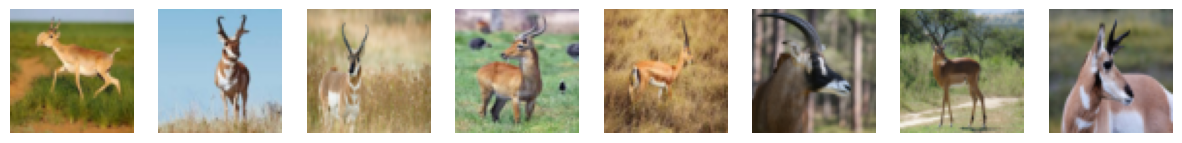

In [ ]:
# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image = dataset[i]["pixel_values"]
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

visualize_images(dataset, num_images=8)

## Generate images from the trained model

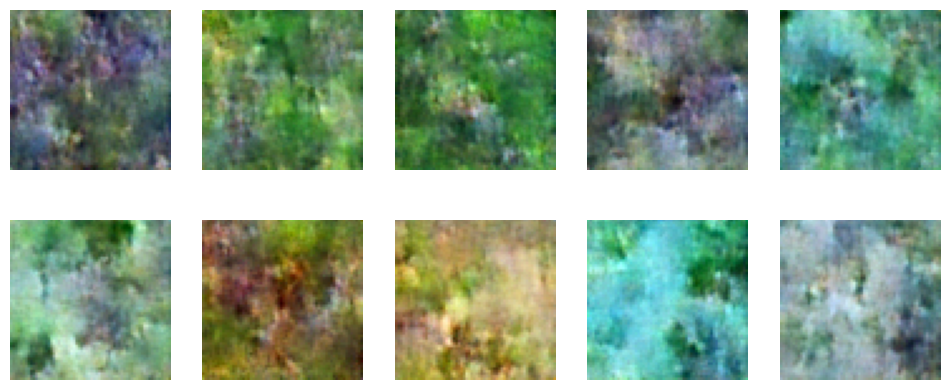

In [ ]:
# Sample images by iterative denoising using the trained model
import torch
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to("cuda")

model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

def generate_images(num_images=15):
    with torch.no_grad():
        noise = torch.randn((num_images, 3, 64, 64)).to("cuda")
        images = noise
        for t in noise_scheduler.timesteps:
            noise_pred = model(images, t).sample
            images = noise_scheduler.step(noise_pred, t, images).prev_sample
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5
        images = torch.clamp(images, 0, 1)
        return images

num_images = 15
generated_images = generate_images(num_images)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()
for i in range(10):
    img = generated_images[i].permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()


In [ ]:
# Save generated images to Google Drive
import os
from matplotlib import pyplot as plt

os.makedirs(drive_path, exist_ok=True)

for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)
    plt.imsave(f"{drive_path}animal_{i:03d}.png", img.numpy())
